<a href="https://colab.research.google.com/github/Cpt-Shaan/RL-Implementations/blob/main/15min_ohlcv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finrl
!pip install pandas_ta
!pip install stable_baselines3
!pip install alpaca-trade-api
!pip install exchange-calendars
!pip install stockstats
!pip install wrds
!pip install websockets
!pip install websocket_client
!pip install pyfolio-reloaded

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=a9e1dcc87c55f4bcf8c81da238f9e7ba4f1069fad9fa8f6a14dbe82b6b6d9a72
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import numpy as np
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3 import PPO, A2C, DDPG, TD3, SAC
from stable_baselines3.common.logger import configure
import pandas_ta as ta

In [ ]:
# 1. Enhanced preprocessing with strict data alignment
def preprocess_multiple_stocks(data_dir, tickers, indicators=['rsi', 'macd']):
    """
    Preprocess multiple 15-min OHLCV files with strict time alignment
    """
    dfs = []
    all_dates = pd.DatetimeIndex([])

    # First pass: Collect all timestamps
    for tic in tickers:
        file_path = os.path.join(data_dir, f"{tic}_15minute_ohlcv.csv")
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
        all_dates = all_dates.union(df['timestamp'])

    # Create complete master index
    full_idx = all_dates.sort_values().unique()

    for tic in tickers:
        file_path = os.path.join(data_dir, f"{tic}_15minute_ohlcv.csv")
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
        df = df.sort_values('timestamp')

        # Create temporary DF with complete index
        full_df = pd.DataFrame(index=full_idx)
        df = df.set_index('timestamp')
        full_df = full_df.join(df, how='left')

        # Fill OHLC prices
        full_df['close'] = full_df['close'].ffill().bfill()
        for col in ['open', 'high', 'low']:
            full_df[col] = full_df[col].fillna(full_df['close'])

        # Fill volume and add indicators
        full_df['volume'] = full_df['volume'].fillna(0)
        full_df['rsi'] = ta.rsi(full_df['close'], length=14)
        macd = ta.macd(full_df['close'], fast=12, slow=26, signal=9)
        full_df['macd'] = macd['MACD_12_26_9']

        # Forward fill technical indicators
        full_df[indicators] = full_df[indicators].ffill().bfill()

        full_df = full_df.dropna()
        full_df.reset_index(inplace=True)
        full_df.rename(columns={'index':'date'}, inplace=True)
        full_df['tic'] = tic
        dfs.append(full_df)

    return pd.concat(dfs, ignore_index=True)

In [ ]:
# 2. Configuration
TICKERS = ['ADANIPORTS.BSE', 'ASIANPAINT.BSE', 'AXISBANK.BSE', 'BAJAJFINSV.BSE', 'BAJFINANCE.BSE', 'CIPLA.BSE', 'HAL.BSE', 'HCLTECH.BSE', 'HDFCBANK.BSE', 'ICICIBANK.BSE', 'IFCI.BSE', 'INDIGO.BSE', 'ITC.BSE', 'JSWSTEEL.BSE', 'LT.BSE', 'MARUTI.BSE', 'ONGC.BSE', 'SBIN.BSE', 'TATAMOTORS.BSE', 'TATASTEEL.BSE', 'TCS.BSE', 'TECHM.BSE', 'TITAN.BSE', 'WIPRO.BSE']  # Replace with your NIFTY stocks
DATA_DIR = 'drive/MyDrive/dataset'
INDICATORS = ['rsi', 'macd']
TRAIN_START = '2021-07-26 09:15:00+05:30'
TRAIN_END = '2024-07-25 15:15:00+05:30'
TEST_START = '2024-07-26 09:15:00+05:30'
TEST_END = '2025-02-13 15:15:00+05:30'
INITIAL_AMOUNT = 1000000
HMAX = 100

print(len(TICKERS))

24


In [ ]:
# 3. Preprocess data
full_df = preprocess_multiple_stocks(DATA_DIR, TICKERS)

In [ ]:
# Critical: Verify all stocks have same timestamps
date_counts = full_df.groupby('date').size()
if not (date_counts == len(TICKERS)).all():
    missing_dates = date_counts[date_counts != len(TICKERS)].index
    print(f"Warning: {len(missing_dates)} dates have incomplete data")
    # Drop incomplete dates for stability
    full_df = full_df[~full_df['date'].isin(missing_dates)]


In [ ]:
full_df

,date,open,high,low,close,volume,oi,rsi,macd,tic
0,2019-01-01 09:15:00+05:30,387.20,387.45,384.50,385.50,15842.0,0.0,52.696215,1.196524,ADANIPORTS.BSE
1,2019-01-01 09:30:00+05:30,385.50,386.10,384.75,385.75,5632.0,0.0,52.696215,1.196524,ADANIPORTS.BSE
2,2019-01-01 09:45:00+05:30,385.75,386.25,385.25,385.45,2475.0,0.0,52.696215,1.196524,ADANIPORTS.BSE
3,2019-01-01 10:00:00+05:30,385.45,385.70,384.40,385.15,4985.0,0.0,52.696215,1.196524,ADANIPORTS.BSE
4,2019-01-01 10:15:00+05:30,385.15,385.40,384.85,385.15,3026.0,0.0,52.696215,1.196524,ADANIPORTS.BSE
...,...,...,...,...,...,...,...,...,...,...
909330,2025-02-14 14:15:00+05:30,305.80,306.90,305.55,306.70,14196.0,0.0,47.970359,-0.834946,WIPRO.BSE
909331,2025-02-14 14:30:00+05:30,306.70,308.40,306.50,308.20,16532.0,0.0,56.100602,-0.608253,WIPRO.BSE
909332,2025-02-14 14:45:00+05:30,308.20,309.20,307.55,308.20,22901.0,0.0,56.100602,-0.423712,WIPRO.BSE
909333,2025-02-14 15:00:00+05:30,308.20,309.00,307.50,307.75,6479.0,0.0,53.207800,-0.310198,WIPRO.BSE


In [ ]:
# Assuming full_df is your DataFrame
full_df.to_csv('processed_data.csv', index=False)

In [ ]:
train_df = data_split(full_df, TRAIN_START, TRAIN_END)
test_df = data_split(full_df, TEST_START, TEST_END)

In [ ]:
train_df

,date,open,high,low,close,volume,oi,rsi,macd,tic
0,2021-07-26 09:15:00+05:30,680.00,684.25,674.60,682.30,50528.0,0.0,51.394854,0.528421,ADANIPORTS.BSE
0,2021-07-26 09:15:00+05:30,3088.95,3088.95,3057.30,3080.00,2128.0,0.0,40.140776,-4.220640,ASIANPAINT.BSE
0,2021-07-26 09:15:00+05:30,756.05,756.05,745.45,752.00,38490.0,0.0,43.753174,0.965048,AXISBANK.BSE
0,2021-07-26 09:15:00+05:30,1324.20,1324.20,1314.85,1322.40,10430.0,0.0,70.023051,4.757551,BAJAJFINSV.BSE
0,2021-07-26 09:15:00+05:30,6160.00,6178.25,6142.50,6175.00,3029.0,0.0,38.778478,-0.460656,BAJFINANCE.BSE
...,...,...,...,...,...,...,...,...,...,...
18524,2024-07-25 15:00:00+05:30,157.20,157.70,157.20,157.30,62474.0,0.0,39.648394,-0.527323,TATASTEEL.BSE
18524,2024-07-25 15:00:00+05:30,4328.00,4328.00,4318.00,4320.90,1591.0,0.0,50.315613,4.201076,TCS.BSE
18524,2024-07-25 15:00:00+05:30,1530.45,1534.00,1527.50,1530.55,1554.0,0.0,52.147145,2.508420,TECHM.BSE
18524,2024-07-25 15:00:00+05:30,3407.60,3407.60,3401.40,3403.95,1575.0,0.0,42.535987,-11.512069,TITAN.BSE


In [ ]:
test_df

,date,open,high,low,close,volume,oi,rsi,macd,tic
0,2024-07-26 09:15:00+05:30,1495.70,1499.00,1489.70,1492.55,16568.0,0.0,54.997578,0.020441,ADANIPORTS.BSE
0,2024-07-26 09:15:00+05:30,2902.35,2923.30,2901.00,2921.65,7003.0,0.0,67.157583,0.441361,ASIANPAINT.BSE
0,2024-07-26 09:15:00+05:30,1167.75,1173.95,1154.80,1170.90,41306.0,0.0,42.213075,-7.058687,AXISBANK.BSE
0,2024-07-26 09:15:00+05:30,1583.00,1583.00,1569.00,1573.70,2218.0,0.0,48.488285,-1.843259,BAJAJFINSV.BSE
0,2024-07-26 09:15:00+05:30,6694.95,6715.00,6670.60,6700.15,6572.0,0.0,72.895481,11.384033,BAJFINANCE.BSE
...,...,...,...,...,...,...,...,...,...,...
3502,2025-02-13 15:00:00+05:30,136.30,136.50,136.05,136.15,14400.0,0.0,56.334746,0.569893,TATASTEEL.BSE
3502,2025-02-13 15:00:00+05:30,3917.15,3918.60,3905.20,3910.00,1292.0,0.0,32.788047,-10.193658,TCS.BSE
3502,2025-02-13 15:00:00+05:30,1673.40,1676.90,1672.05,1676.90,255.0,0.0,48.056898,-0.772397,TECHM.BSE
3502,2025-02-13 15:00:00+05:30,3236.90,3245.55,3230.00,3230.80,362.0,0.0,36.774034,-8.422423,TITAN.BSE


In [ ]:
# 4. Environment setup
stock_dim = len(TICKERS)
state_space = 1 + 2*stock_dim + len(INDICATORS)*stock_dim
buy_cost_list = sell_cost_list = [0.001] * stock_dim
num_stock_shares = [0] * stock_dim

print(stock_dim, state_space)

24 97


In [ ]:
env_kwargs = {
    "hmax": HMAX,
    "initial_amount": INITIAL_AMOUNT,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dim,
    "tech_indicator_list": ['rsi', 'macd'],
    "action_space": stock_dim,
    "reward_scaling": 1e-4
}

In [ ]:
# Verify state space calculation
print(f"Calculated state space: {state_space}")
print(f"Unique stocks in train: {train_df['tic'].nunique()}")
print(f"Unique dates in train: {train_df['date'].nunique()}")

Calculated state space: 97
Unique stocks in train: 24
Unique dates in train: 18525


In [ ]:
# 5. Create environments with validation
def create_env(df, env_kwargs):
    env = StockTradingEnv(df=df, **env_kwargs)
    # Validate state dimension
    obs = env.reset()
    if len(obs[0]) != env_kwargs['state_space']:
        print(f"CRITICAL: State dim mismatch. Expected {env_kwargs['state_space']}, got {len(obs)}")
        print(f"Components: [Balance] + [Prices] + [Holdings] + [Indicators]")
        print(f"1 + {stock_dim} + {stock_dim} + {stock_dim * len(INDICATORS)}")
    return env

train_env = create_env(train_df, env_kwargs)
test_env = create_env(test_df, env_kwargs)

In [ ]:
obs = train_env.reset()
print(len(obs))
print(obs[0])
print(obs[1])
print(len(obs[0]))
print(len(obs[1]))

2
[1000000, 682.3, 3080.0, 752.0, 1322.4, 6175.0, 956.6, 559.0, 993.9, 1442.4, 673.85, 14.25, 1755.45, 214.4, 716.9, 1621.3, 7270.35, 108.5, 426.25, 294.65, 125.3, 3216.8, 1107.55, 1710.65, 292.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51.3948539813376, 40.14077562526132, 43.75317370198257, 70.02305116774872, 38.778477913869985, 70.49569131307828, 54.42255700319939, 55.91032035320036, 43.850032694966934, 62.136202786545034, 37.85090617093119, 67.41659950440054, 81.46438672536895, 49.48207853234817, 51.77340323432799, 31.93684127876451, 38.328971361432835, 56.6776367609528, 31.813836707403695, 61.86753803276785, 44.76473414270875, 55.70256760355732, 56.46169799184386, 56.226275007308445, 0.5284214061573493, -4.220640375231142, 0.9650481840017164, 4.75755095010345, -0.46065642473240587, -0.09229638693091147, -1.6535421418009264, 1.7115863207072834, -1.2236577674200362, 4.268984535929917, -0.07640565445630898, 8.681159501004231, 1.5425510218949796, 1.61975

In [ ]:
# 6. Initialize DRL Agent
agent = DRLAgent(env=train_env)

In [ ]:
print(train_df.groupby('tic').size())  # Should be equal for all stocks
print(train_df[['tic', 'date', 'rsi', 'macd']].isna().sum())

tic
ADANIPORTS.BSE    18525
ASIANPAINT.BSE    18525
AXISBANK.BSE      18525
BAJAJFINSV.BSE    18525
BAJFINANCE.BSE    18525
CIPLA.BSE         18525
HAL.BSE           18525
HCLTECH.BSE       18525
HDFCBANK.BSE      18525
ICICIBANK.BSE     18525
IFCI.BSE          18525
INDIGO.BSE        18525
ITC.BSE           18525
JSWSTEEL.BSE      18525
LT.BSE            18525
MARUTI.BSE        18525
ONGC.BSE          18525
SBIN.BSE          18525
TATAMOTORS.BSE    18525
TATASTEEL.BSE     18525
TCS.BSE           18525
TECHM.BSE         18525
TITAN.BSE         18525
WIPRO.BSE         18525
dtype: int64
tic     0
date    0
rsi     0
macd    0
dtype: int64


In [ ]:
# Training A2C

model_a2c = agent.get_model('a2c')
# Set up logger
tmp_path = os.path.join('results_multiple', 'a2c')
logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_a2c.set_logger(logger)

# Train model
trained_model_a2c = agent.train_model(
    model=model_a2c,
    tb_log_name='a2c',
    total_timesteps=20000
)

trained_model_a2c.save(os.path.join('trained_multiple', f"agent_a2c"))


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to results_multiple/a2c
-------------------------------------
| time/                 |           |
|    fps                | 19        |
|    iterations         | 100       |
|    time_elapsed       | 25        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -34.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -11.5     |
|    reward             | 1.9228159 |
|    std                | 1.01      |
|    value_loss         | 0.133     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 20       |
|    iterations         | 200      |
|    time_elapsed       | 47       |
|    total_timesteps  

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'trained_multiple' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
# Train model
trained_model_a2c = agent.train_model(
    model=trained_model_a2c,
    tb_log_name='a2c',
    total_timesteps=50000
)

trained_model_a2c.save(os.path.join('trained_multiple', f"agent_a2c"))

-------------------------------------
| time/                 |           |
|    fps                | 21        |
|    iterations         | 100       |
|    time_elapsed       | 23        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 4099      |
|    policy_loss        | -13.9     |
|    reward             | 0.335343  |
|    std                | 1.37      |
|    value_loss         | 0.124     |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 21        |
|    iterations         | 200       |
|    time_elapsed       | 45        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.8     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updat

In [ ]:
trained_model_a2c = A2C.load("trained_multiple" + "/agent_a2c")

In [ ]:
df_account_value_a2c, _ = DRLAgent.DRL_prediction(
                model=trained_model_a2c,
                environment=test_env
            )

# Financial metrics
df_account_value_a2c['date'] = pd.to_datetime(df_account_value_a2c['date'])
df_account_value_a2c['date'] = df_account_value_a2c['date'].dt.tz_localize(None)

# Calculate returns
initial_val = INITIAL_AMOUNT
final_val = df_account_value_a2c['account_value'].iloc[-1]
total_return = (final_val - initial_val) / initial_val * 100

print("A2C Performance:")
print(f" - Initial Capital: ₹{initial_val:,.2f}")
print(f" - Final Equity: ₹{final_val:,.2f}")
print(f" - Total Return: {total_return:.2f}%")

hit end!
A2C Performance:
 - Initial Capital: ₹1,000,000.00
 - Final Equity: ₹959,714.64
 - Total Return: -4.03%


In [ ]:
# Training PPO

model_ppo = agent.get_model('ppo')
# Set up logger
tmp_path = os.path.join('results_multiple', 'ppo')
logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_ppo.set_logger(logger)

# Train model
trained_model_ppo = agent.train_model(
    model=model_ppo,
    tb_log_name='ppo',
    total_timesteps=50000
)

trained_model_ppo.save(os.path.join('trained_multiple', f"agent_ppo"))

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to results_multiple/ppo


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/              |             |
|    fps             | 21          |
|    iterations      | 1           |
|    time_elapsed    | 93          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.08366033 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 188          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.008796663  |
|    clip_fraction        | 0.141        |
|    clip_range           | 0.2          |
|    entropy_loss         | -34.1        |
|    explained_variance   | -0.282       |
|    learning_rate        | 0.00025      |
|    loss                 | -0.264       |
|    n_updates            | 10           |
|    policy_gradient_l

In [ ]:
trained_model_ppo = PPO.load("trained_multiple" + "/agent_ppo")

In [ ]:
df_account_value_ppo, _ = DRLAgent.DRL_prediction(
                model=trained_model_ppo,
                environment=test_env
            )

# Financial metrics
df_account_value_ppo['date'] = pd.to_datetime(df_account_value_ppo['date'])
df_account_value_ppo['date'] = df_account_value_ppo['date'].dt.tz_localize(None)

# Calculate returns
initial_val = INITIAL_AMOUNT
final_val = df_account_value_ppo['account_value'].iloc[-1]
total_return = (final_val - initial_val) / initial_val * 100

print("PPO Performance:")
print(f" - Initial Capital: ₹{initial_val:,.2f}")
print(f" - Final Equity: ₹{final_val:,.2f}")
print(f" - Total Return: {total_return:.2f}%")

hit end!
PPO Performance:
 - Initial Capital: ₹1,000,000.00
 - Final Equity: ₹1,077,065.78
 - Total Return: 7.71%


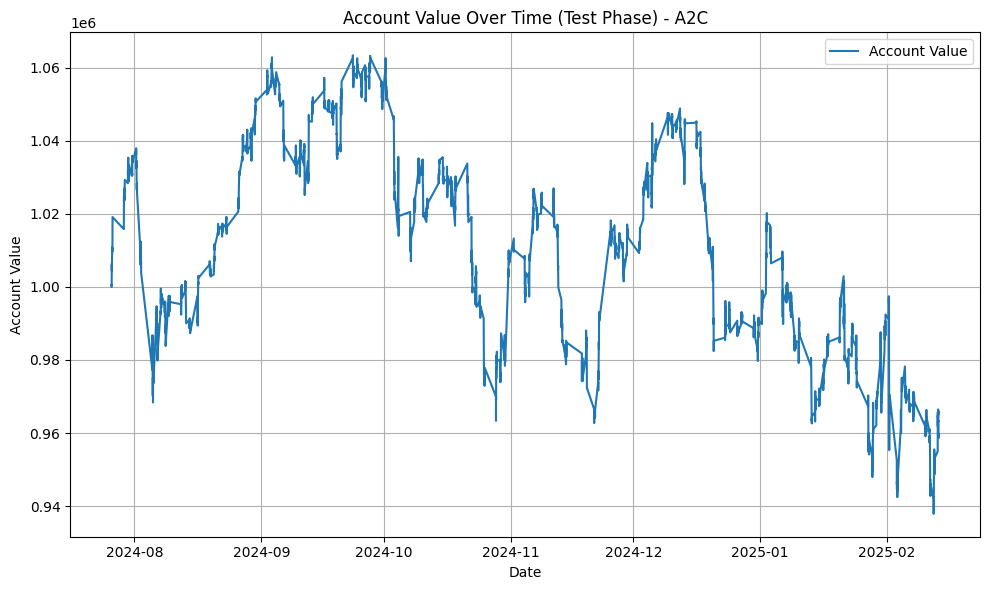

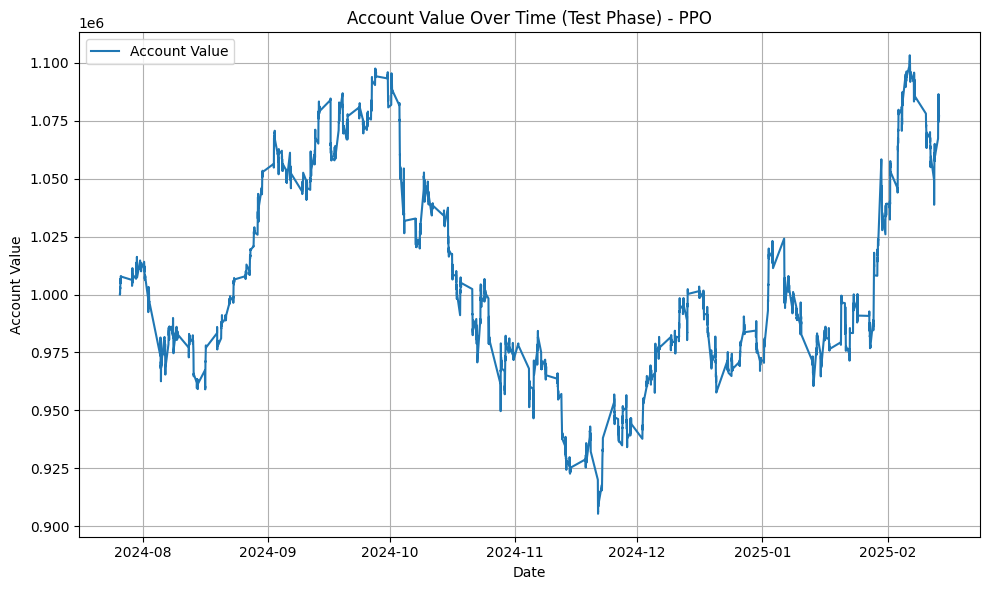

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(df_account_value_a2c['date'], df_account_value_a2c['account_value'], label='Account Value')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value Over Time (Test Phase) - A2C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_account_value_ppo['date'], df_account_value_ppo['account_value'], label='Account Value')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value Over Time (Test Phase) - PPO')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()